# Toy model evaluation of FE estimation and clustering 

In [1]:
import numpy as np
import toy_models
import GMM_FE
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

In [35]:
toy_model = 'GMM_2D'

x_lims = [[0,1],[0,1]]
stack_landscapes=False
# Create model
if toy_model == 'mGMMs':
    tm = toy_models.MultipleGMMs()
elif toy_model == 'digits':
    tm = toy_models.Digits()
    x_lims = [[-30,30],[-30,30]]
elif toy_model == 'nonlinear_GMM_2D':
    tm = toy_models.GMM2dNonlinear()
    x_lims = [[-1.5,0.5],[-4,1.75]]
else:
    tm = toy_models.GMM2D()

nx = 50

Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Point: 2000/2000
Constructing connected components.
# Graph connections: 29922.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6. 7.]
Assigning cluster indices to non-core cluster points.
Done clustering.


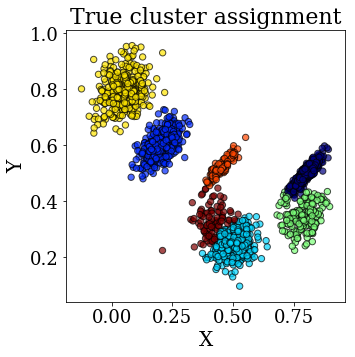

In [15]:
# Sample from model
save_data=False

for i in range(1,2):
    data = tm.sample(2000)
    if save_data:
        np.savetxt('sampled_data_'+tm.name+str(i)+'.txt',data)

    #data = tm.sample(1500)

    # Compute true density at points
    data_density = tm.density(data)

    # Get cluster labels
    if hasattr(tm,"assign_cluster_labels"):
        labels = tm.assign_cluster_labels(data)
    else:
        true_fe = GMM_FE.FreeEnergy(data,x_lims=x_lims,n_grids=nx,verbose=False,stack_landscapes=stack_landscapes)
        true_fe.density_est_ = tm
        coords, density = true_fe._density_landscape(tm)

        # Compute true free energy
        FE_landscape = true_fe._free_energy(density)
        min_FE = np.min(FE_landscape)
        FE_landscape = FE_landscape-min_FE

        FE_points = true_fe._free_energy(data_density)-min_FE

        # Set true free energies
        true_fe.coords_ = coords
        true_fe.FE_landscape_ = FE_landscape
        true_fe.FE_points_ = FE_points
        #labels, cluster_centers = true_fe.cluster(coords,FE_points,data,assign_transition_points=True)
        labels, cluster_centers = true_fe.cluster(data,FE_points,assign_transition_points=True)
    
    if save_data:
        np.save('cluster_labels_'+tm.name+str(i)+'.npy',labels)

fig=plt.figure(1,figsize=(5,5))
ax=fig.add_subplot(111)
ax.scatter(data[:,0],data[:,1],c=labels,alpha=0.7,cmap='jet',edgecolor='k',s=40)
#plt.scatter(data[:,0],data[:,1],c=tm.labels_,alpha=0.7,cmap='jet',edgecolor='k',s=80)
plt.xlabel('X',fontsize=20,fontname='serif',fontweight='light')
plt.ylabel('Y',fontsize=20,fontname='serif',fontweight='light')
plt.title('True cluster assignment',fontsize=22,fontname='serif',fontweight='light')
plt.tick_params(axis='both', which='major', labelsize=18)

for tick in ax.get_xticklabels():
    tick.set_fontname("Serif")
    tick.set_fontweight('light')
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Serif")
    tick.set_fontweight('light')
    
#plt.savefig(toy_model+'_true_clustering.svg')
plt.show()

Density grid shape: (100, 100)


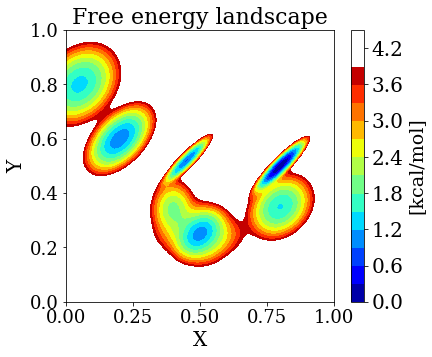

In [16]:
# Create a free energy object with known toy model
true_fe = GMM_FE.FreeEnergy(data,x_lims=x_lims,n_grids=100,verbose=False,stack_landscapes=stack_landscapes)
true_fe.density_est_ = tm
coords, density = true_fe._density_landscape(tm)

# Compute true free energy
FE_landscape = true_fe._free_energy(density)
min_FE = np.min(FE_landscape)
FE_landscape = FE_landscape-min_FE

FE_points = true_fe._free_energy(data_density)-min_FE

# Set true free energies
true_fe.coords_ = coords
true_fe.FE_landscape_ = FE_landscape
true_fe.FE_points_ = FE_points

# Visualize the model
true_fe.visualize(show_data=False,savefig=False,vmax=4,xlabel='X',ylabel='Y',figsize=[6,5],fontsize=22)
plt.xlabel('X',fontsize=20,fontname='serif',fontweight='light')
plt.ylabel('Y',fontsize=20,fontname='serif',fontweight='light')
plt.title('Free energy landscape',fontsize=22,fontname='serif',fontweight='light')
plt.tick_params(axis='both', which='major', labelsize=18)

for tick in ax.get_xticklabels():
    tick.set_fontname("Serif")
    tick.set_fontweight('light')
    
for tick in ax.get_yticklabels():
    tick.set_fontname("Serif")
    tick.set_fontweight('light')

plt.savefig(toy_model+'_free_energy_landscape.svg')
plt.show()

In [17]:
# Cluster data
if hasattr(tm,"assign_cluster_labels"):
    labels = tm.assign_cluster_labels(data)
    true_fe.labels_=labels
else:
    #labels, cluster_centers = true_fe.cluster(coords,FE_points,data,assign_transition_points=True)
    labels, cluster_centers = true_fe.cluster(data,FE_points,assign_transition_points=True)

Clustering free energy landscape...
Computing Hessians.
Point: 2000/2000
Constructing connected components.
# Graph connections: 29922.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6. 7.]
Assigning cluster indices to non-core cluster points.
Done clustering.


[1286  320 1515 1426 1449 1523  703]


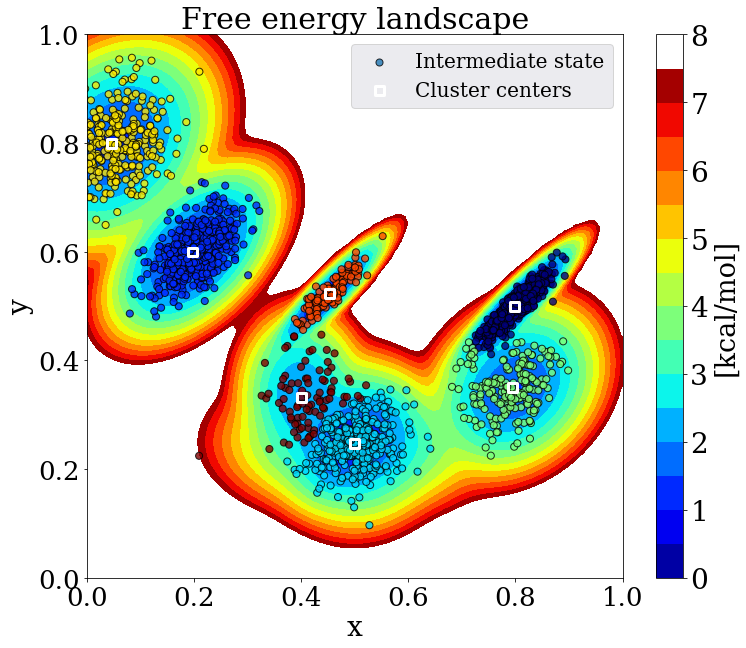

In [18]:
# Visualize true clusters
true_fe.visualize(show_data=True)
#plt.scatter(true_fe.cl_.grid_points_[:,0],true_fe.cl_.grid_points_[:,1],c=true_fe.is_FE_min)
plt.savefig(toy_model+'_true_clustering.svg')
print(cluster_centers)

In [38]:
# Estimate free energy and clustering with GMM and cross-validation
stack_landscapes = False

gmm_FE = GMM_FE.FreeEnergy(data,min_n_components=2,max_n_components=12, n_components_step=1, x_lims=true_fe.x_lims_, 
                           n_grids=nx, stack_landscapes=stack_landscapes, n_iterations=7, convergence_tol=1e-7, n_splits=1)

est_coords, est_FE_landscape, est_FE_points = gmm_FE.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 7
   n_grids = 50
   covergence_tol = 1e-07
   stack_landscapes = False
   x_lims (axes limits) = [[0, 1], [0, 1]]
   temperature = 300.0
   min_n_components = 2
   max_n_components = 12
   n_components_step = 1
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 2
# Components = 3
# Components = 4
# Components = 5
# Components = 6


/home/anniewe/program/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


# Components = 7
# Components = 8
# Components = 9
# Components = 10
# Components = 11
# Components = 12
Identifying final model with 7 components.
Evaluating density in landscape
Density grid shape: (50, 50)


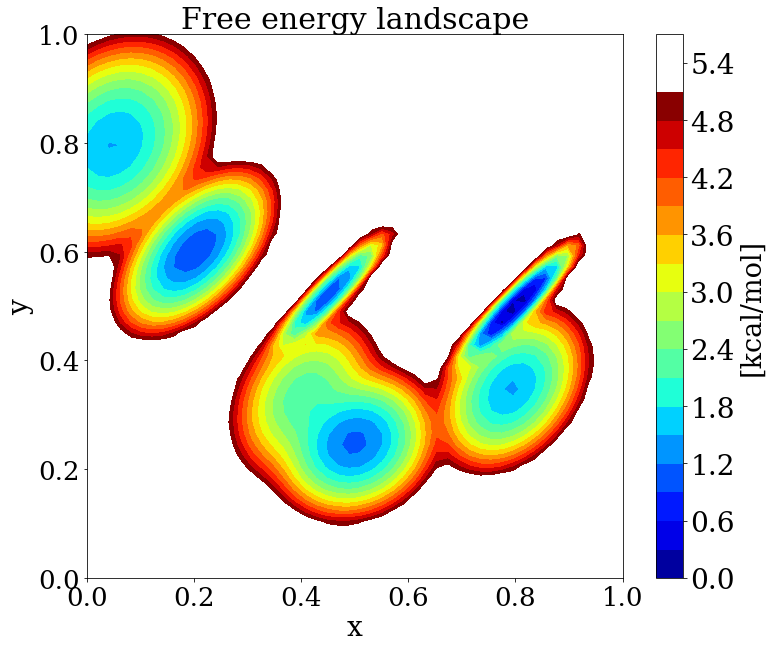

In [39]:
# Visualize estimated free energy landscape and the true free energy contours
gmm_FE.visualize(show_data=False,vmax=5,n_contour_levels=20)

if stack_landscapes:
    # Plot the model weights
    plt.figure(2)
    plt.plot(gmm_FE.density_est_.n_components_list_,gmm_FE.density_est_.model_weights_,linewidth=2,marker='o',color=[0.56,0.56,0.6],markersize=10)
    
    # Plot each indivudual model
    n_models = gmm_FE.density_est_.n_models_
    for i_model in range(n_models):
        # Create a free energy object with known toy model
        mod_fe = GMM_FE.FreeEnergy(data,x_lims=true_fe.x_lims_,n_grids=true_fe.nx_,verbose=False)
        mod_fe.density_est_ = gmm_FE.density_est_.GMM_list_[i_model]
        mod_coords, density = mod_fe.density_landscape()
        
        # Compute true free energy
        mod_FE_landscape = mod_fe._free_energy(density)
        mod_min_FE = np.min(mod_FE_landscape)
        mod_FE_landscape = mod_FE_landscape-mod_min_FE

        # Set true free energies
        mod_fe.coords_ = mod_coords
        mod_fe.FE_landscape_ = mod_FE_landscape

        # Visualize the model
        mod_fe.visualize(show_data=True)

In [47]:
# Cluster based on estimated density model
est_labels, est_cluster_centers = gmm_FE.cluster(data,est_FE_points,assign_transition_points=False, use_FE_landscape=True)

Clustering free energy landscape...
Computing Hessians.
Point: 2000/2000
Constructing connected components.
# Graph connections: 10312.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6. 7.]
Done clustering.


[1286  176 1515 1426 1449 1523 1478]
[1286  176 1515 1426 1449 1523 1478]
7


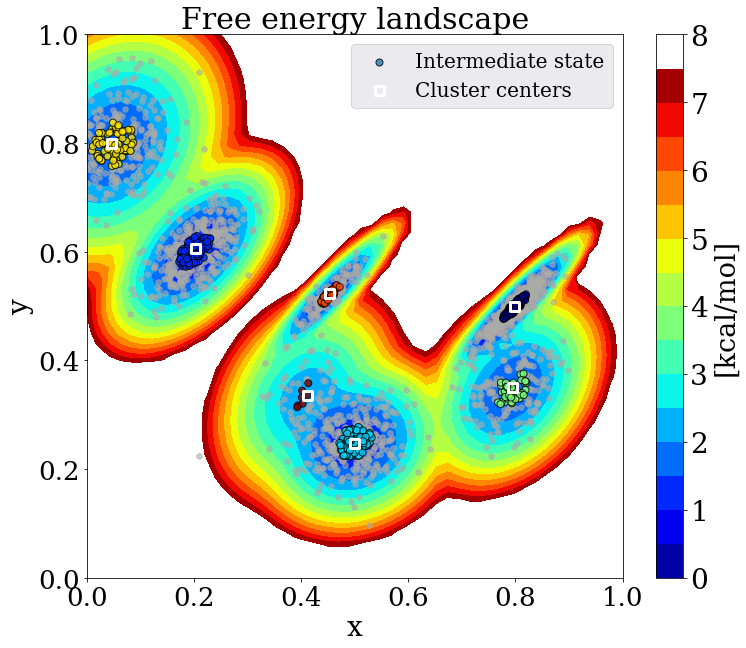

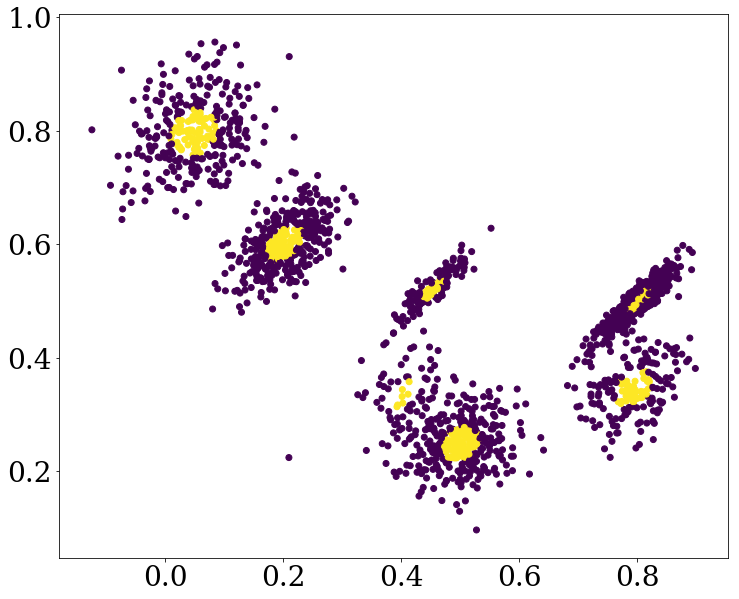

In [48]:
print(gmm_FE.cluster_centers_)
gmm_FE.visualize(show_data=True)

plt.figure(2)
plt.scatter(gmm_FE.cl_.grid_points_[:,0],gmm_FE.cl_.grid_points_[:,1],c=gmm_FE.is_FE_min)
print(est_cluster_centers)
if not(stack_landscapes):
    print(gmm_FE.density_est_.n_components_)

# Evaluate clustering methods on toy models

In [7]:
# Evaluate each toy_model
toy_model_list = ['nonlinear_GMM_2D','GMM_2D','mGMMs'] #['nonlinear_GMM_2D','GMM_2D','mGMMs','digits']

tm_evals = []
for toy_model in toy_model_list:
    # Get presampled data (making sure that we evaluated on the same dataset as density peaks)
    sampled_data = []
    true_clustering = []
    for i in range(1,51):
        sampled_data.append(np.loadtxt('data/toy_model/sampled_data_'+toy_model+str(i)+'.txt'))
        true_clustering.append(np.load('data/toy_model/cluster_labels_'+toy_model+str(i)+'.npy'))
    sampled_data = np.asarray(sampled_data)
    true_clustering = np.asarray(true_clustering)
    presampled_data = [sampled_data,true_clustering]
    
    te = toy_models.MethodEvaluator(convergence_tol=1e-7,toy_model=toy_model,verbose=False,presampled_data=presampled_data)
    te.run_evaluation(n_iterations=7, min_n_components=2, max_n_components=15, n_splits=1, save_data=True)
    tm_evals.append(te)

Setting true model.
Density grid shape: (30, 30)
Run: 1/50
Estimating density with GMM.


/home/anniewe/program/anaconda3/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Identifying final model with 4 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 95522.0
Clustering data points.
Cluster labels: [0. 1. 2. 3.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster data with K-means
Cluster labels: [1 2]
Cluster data with agglomerative-Ward
Cluster labels: [1 2]
Cluster data with spectral clustering
Spectral embedding
Cluster data with 7 clusters.
Cluster labels: [1 2 3 4 5 6 7]
Run: 2/50
Estimating density with GMM.
Identifying final model with 4 components.
Evaluating density in landscape
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 117894.0
Clustering data points.
Cluster labels: [0. 1. 2. 3.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster data with K-means
Cluster la

In [10]:
# Load already performed density peaks clustering, and save the resulting V-measure
n_samplings = 50
toy_model_list = ['nonlinear_GMM_2D','GMM_2D','mGMMs']
te = toy_models.MethodEvaluator(convergence_tol=1e-7,toy_model='nonlinear_GMM_2D',verbose=False)

for toy_model in toy_model_list:
    vm_scores = np.zeros(n_samplings)
    for i_sample in range(n_samplings):
        te.true_labels_ = np.load('data/toy_model/cluster_labels_'+toy_model+str(i_sample+1)+'.npy')
        density_peaks_labels = np.loadtxt('data_out/density_peaks_cluster_labels/density_peaks_labels_downweight_rho_'+toy_model+str(i_sample+1)+'.txt')
        vm_scores[i_sample] = te._score_clustering(density_peaks_labels,metric='vm')
    np.save('data_out/cluster_score_vm_density_peaks_dw_rho_'+toy_model+'.npy',vm_scores)


Setting true model.
Density grid shape: (30, 30)


In [12]:
# Read previously generated data (cluster scores) and put in evaluator objects in order to do visualization
tm_evals = []

toy_model_list = ['nonlinear_GMM_2D','GMM_2D','mGMMs']

for toy_model in toy_model_list:
    te = toy_models.MethodEvaluator(convergence_tol=1e-7,toy_model=toy_model,verbose=False)
    te.cluster_score_ami_kmeans_ = np.load('data_out/cluster_score_ami_kmeans_'+toy_model+'.npy')
    te.cluster_score_vm_kmeans_ = np.load('data_out/cluster_score_vm_kmeans_'+toy_model+'.npy')
    te.cluster_score_fm_kmeans_ = np.load('data_out/cluster_score_fm_kmeans_'+toy_model+'.npy')

    te.cluster_score_ami_AW_ = np.load('data_out/cluster_score_ami_AW_'+toy_model+'.npy')
    te.cluster_score_vm_AW_ = np.load('data_out/cluster_score_vm_AW_'+toy_model+'.npy')
    te.cluster_score_fm_AW_ = np.load('data_out/cluster_score_fm_AW_'+toy_model+'.npy')

    te.cluster_score_ami_spectral_ = np.load('data_out/cluster_score_ami_spectral_'+toy_model+'.npy')
    te.cluster_score_vm_spectral_ = np.load('data_out/cluster_score_vm_spectral_'+toy_model+'.npy')
    te.cluster_score_fm_spectral_ = np.load('data_out/cluster_score_fm_spectral_'+toy_model+'.npy')

    te.cluster_score_vm_density_peaks_ = np.load('data_out/cluster_score_vm_density_peaks_dw_rho_'+toy_model+'.npy')
    
    te.cluster_score_ami_GMM_ = np.load('data_out/cluster_score_ami_GMM_'+toy_model+'.npy')
    te.cluster_score_vm_GMM_ = np.load('data_out/cluster_score_vm_GMM_'+toy_model+'.npy')
    te.cluster_score_fm_GMM_ = np.load('data_out/cluster_score_fm_GMM_'+toy_model+'.npy')

    te.cluster_score_ami_GMM_FE_min_ = np.load('data_out/cluster_score_ami_FE_min_'+toy_model+'.npy')
    te.cluster_score_vm_GMM_FE_min_ = np.load('data_out/cluster_score_vm_FE_min_'+toy_model+'.npy')
    te.cluster_score_fm_GMM_FE_min_ = np.load('data_out/cluster_score_fm_FE_min_'+toy_model+'.npy')

    tm_evals.append(te)
print('Done fetching data.')    

Setting true model.
Density grid shape: (30, 30)
Setting true model.
Density grid shape: (30, 30)
Clustering free energy landscape...
Computing Hessians.
Constructing connected components.
# Graph connections: 106.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5. 6.]
Done clustering.
Setting true model.
Density grid shape: (30, 30)
Done fetching data.


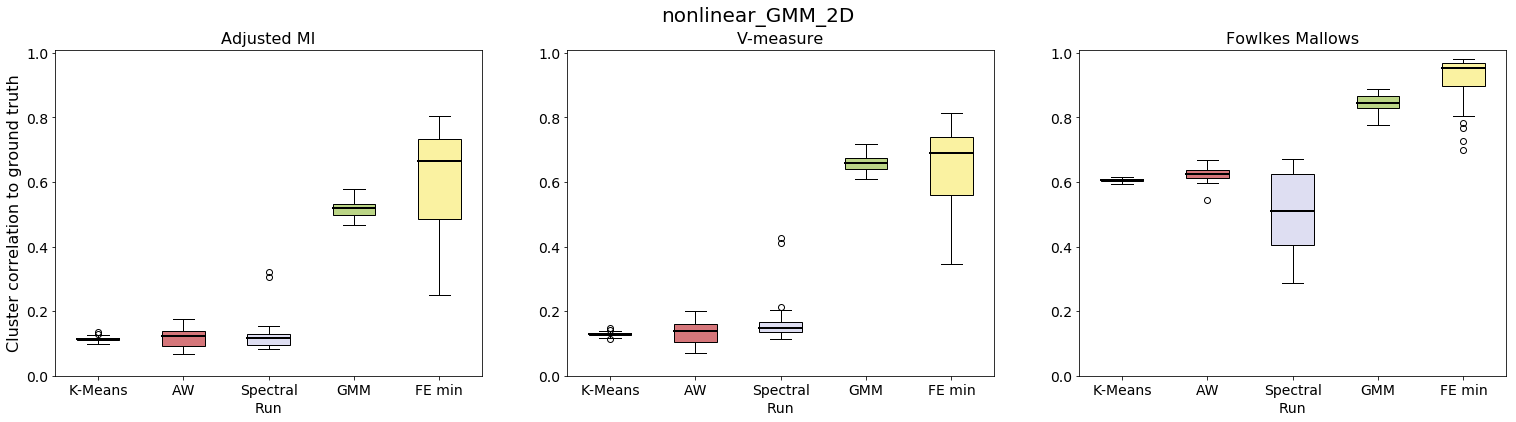

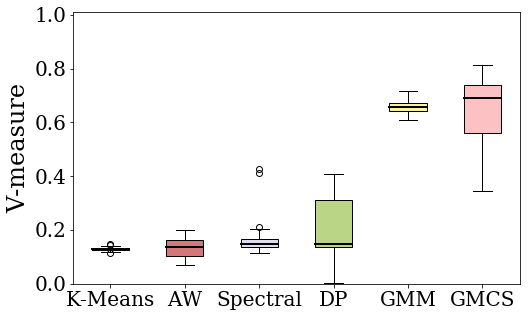

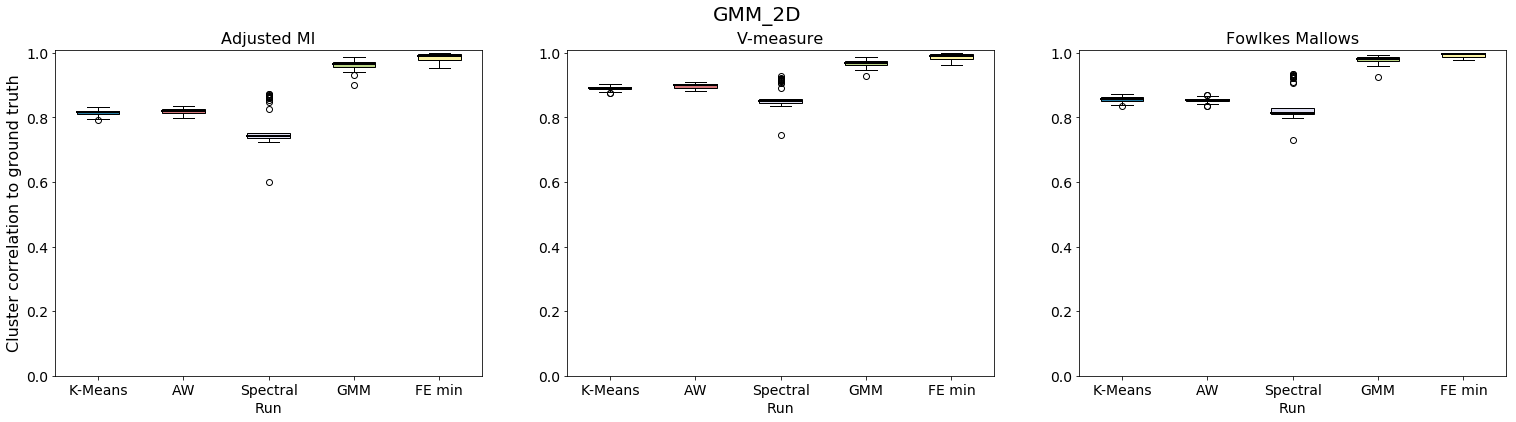

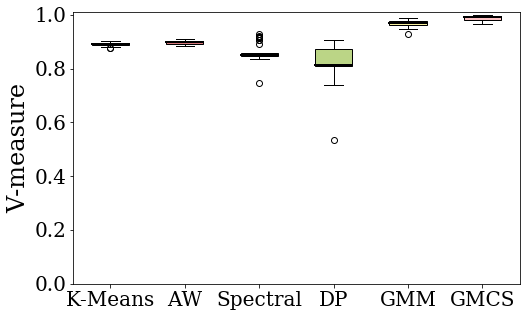

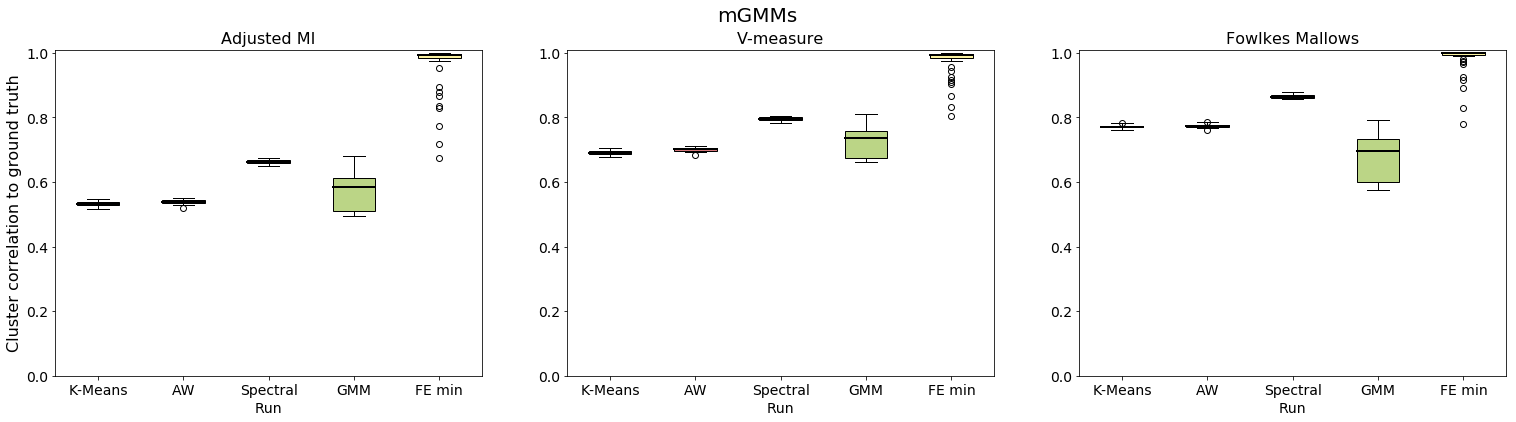

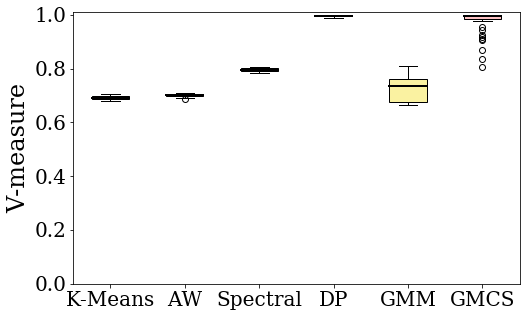

In [13]:
# Plot data
counter=1
n_runs=50
alpha=0.5
show_data=False
facecolors = [[0.141,0.482,0.637],[0.837,0.463,0.478],[0.87,0.87,0.95],[0.733,0.837,0.525],[0.98,0.949,0.631],[0.99,0.757,0.765]]

for te in tm_evals:
    fig=plt.figure(counter,figsize=(26,6))
    ax = fig.add_subplot(131) 
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_ami_kmeans_,te.cluster_score_ami_AW_,te.cluster_score_ami_spectral_,te.cluster_score_ami_GMM_,te.cluster_score_ami_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','GMM','FE min'],patch_artist=True)
    
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_ami_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.title('Adjusted MI',fontsize=16)
    plt.xlabel("Run",fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylabel("Cluster correlation to ground truth",fontsize=16)
    plt.ylim([0,1.01])
    
    ax = fig.add_subplot(132) 
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_vm_kmeans_,te.cluster_score_vm_AW_,te.cluster_score_vm_spectral_,te.cluster_score_vm_GMM_,te.cluster_score_vm_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','GMM','FE min'],patch_artist=True)
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
    
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.title('V-measure',fontsize=16)
    plt.xlabel("Run",fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.ylim([0,1.01])
    
    ax = fig.add_subplot(133)
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_fm_kmeans_,te.cluster_score_fm_AW_,te.cluster_score_fm_spectral_,te.cluster_score_fm_GMM_,te.cluster_score_fm_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','GMM','FE min'],patch_artist=True)
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
        
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_fm_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.title('Fowlkes Mallows',fontsize=16)
    counter+=1
    #plt.legend(fontsize=16)
    plt.ylim([0,1.01])
    plt.suptitle(te.toy_model_.name,fontsize=20)
    plt.xlabel("Run",fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)

    ############################################
    # Make a figure with only V-measure score  #
    ############################################
    fig = plt.figure(counter,figsize=(8,5))
    ax = fig.add_subplot(111)
    medianprops = dict(color='k',linewidth=2)
    boxprops = dict(color='k',linewidth=1,facecolor=[0.87,0.9,0.9])
    bp=ax.boxplot([te.cluster_score_vm_kmeans_,te.cluster_score_vm_AW_,te.cluster_score_vm_spectral_,te.cluster_score_vm_density_peaks_,te.cluster_score_vm_GMM_,te.cluster_score_vm_GMM_FE_min_],
               notch=False, medianprops=medianprops, boxprops=boxprops,labels=['K-Means','AW','Spectral','DP','GMM','GMCS'],patch_artist=True)
    
    counter2=0
    for patch in bp['boxes']:
        patch.set(facecolor=facecolors[counter2],alpha=1) 
        counter2+=1
    
    if show_data:
        plt.scatter(1*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_kmeans_,label="K-means clusters",s=40,alpha=alpha,color=facecolors[0])
        plt.scatter(2*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_AW_,label="Ward clusters",s=40,alpha=alpha,color=facecolors[1])
        plt.scatter(3*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_spectral_,label="Spectral clusters",s=40,alpha=alpha,color=facecolors[2])
        plt.scatter(4*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_GMM_,label="GMM clusters",s=40,alpha=alpha,color=facecolors[3])
        plt.scatter(5*np.ones(n_runs)+(0.2*np.random.rand(n_runs)-0.1),te.cluster_score_vm_GMM_FE_min_,label="FE min clusters",s=40,alpha=alpha,color=facecolors[4])
    plt.ylabel('V-measure',fontsize=24,fontname='Serif',fontweight='light')
    plt.tick_params(axis='both', which='major', labelsize=20)
    
    for tick in ax.get_xticklabels():
        tick.set_fontname("Serif")
        tick.set_fontweight('light')
    
    for tick in ax.get_yticklabels():
        tick.set_fontname("Serif")
        tick.set_fontweight('light')  
    plt.ylim([0.0,1.01])
    
    counter+=1
    
    plt.savefig(te.toy_model_.name+'_vmeasure_score.svg')

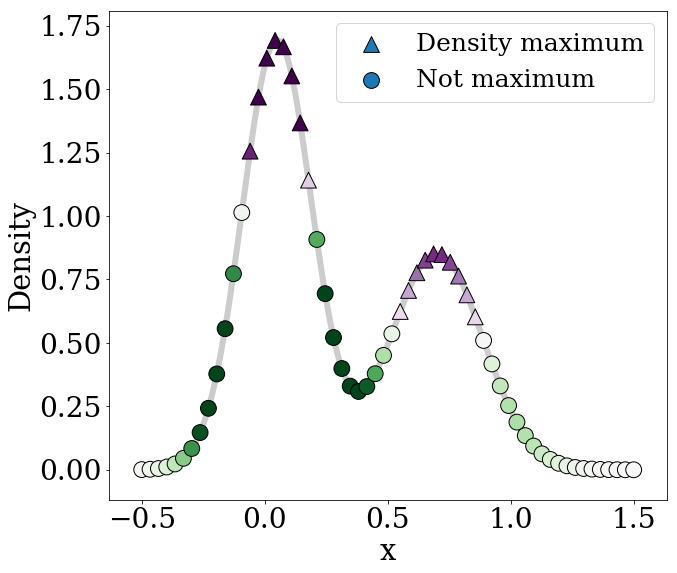

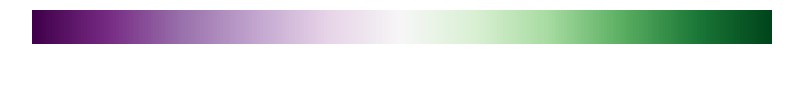

In [48]:
# 1D example of second derivative
from GMM_FE.GMM import GaussianMixture
from GMM_FE.FE_landscape_clustering import LandscapeClustering

def plot_color_gradient(cmap_name):
    fig = plt.figure(2,figsize=(13,0.5))
    ax = fig.add_subplot(1,1,1)
    #fig, axes = plt.subplots(nrows=1)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
    gradient = np.linspace(-30, 30, 256)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(cmap_name))
    pos = list(ax.get_position().bounds)
    x_text = pos[0] - 0.01
    y_text = pos[1] + pos[3]/2.
    # Turn off *all* ticks & spines, not just the ones with colormaps.
    ax.set_axis_off()

GMM = GaussianMixture(n_components=2)
GMM.means_ = np.asarray([0.05*np.ones(1),0.7*np.ones(1)])
GMM.covariances_ = [0.02*np.ones((1,1)),0.035*np.ones((1,1))]
GMM.weights_ = np.asarray([0.6,0.4])

x_plot = np.linspace(-0.5,1.5,200)
x = np.linspace(-0.5,1.5,60)
second_derivatives = np.zeros(x.shape)

cmap_name = 'PRGn'

inv_covs = []
for i in range(len(GMM.covariances_)):
    inv_covs.append(1.0/GMM.covariances_[i])

LC = LandscapeClustering()

for i in range(x.shape[0]):
    second_derivatives[i] = LC._compute_GMM_Hessian(GMM, x[i,np.newaxis], inv_covs)

fig=plt.figure(1,figsize=(10,9))
ax = fig.add_subplot(111)
plt.plot(x_plot,GMM.density(x_plot),color=[0.8,0.8,0.8],linewidth=6,zorder=0)
ax.scatter(x[second_derivatives<0],GMM.density(x[second_derivatives<0]),s=250,c=second_derivatives[second_derivatives<0],vmin=-30,vmax=30,cmap=cmap_name,marker='^',edgecolor='k',label='Density maximum',zorder=1)
ax.scatter(x[second_derivatives>0],GMM.density(x[second_derivatives>0]),s=250,c=second_derivatives[second_derivatives>0],vmin=-30,vmax=30,cmap=cmap_name,edgecolor='k',label='Not maximum',zorder=2)

plt.xlabel('x',fontsize=29,fontname='serif',fontweight='light')
plt.ylabel('Density',fontsize=29,fontname='serif',fontweight='light')
lh = plt.legend(fontsize=25)
plt.setp(lh.texts, family='serif')


fig = plt.figure(2,figsize=(13,0.5))
ax = fig.add_subplot(1,1,1)
#fig, axes = plt.subplots(nrows=1)
fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
gradient = np.linspace(-30, 30, 256)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap(cmap_name))
pos = list(ax.get_position().bounds)
x_text = pos[0] - 0.01
y_text = pos[1] + pos[3]/2.
# Turn off *all* ticks & spines, not just the ones with colormaps.
ax.set_axis_off()


for tick in ax.get_xticklabels():
    tick.set_fontname("Serif")
    tick.set_fontweight('light')

for tick in ax.get_yticklabels():
    tick.set_fontname("Serif")
    tick.set_fontweight('light')  

    plt.savefig('density_second_derivative.svg')